<a href="https://colab.research.google.com/github/kmamaroziqov/Music-Genre-Classifaction/blob/main/Music_genre_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install -q kaggle

In [18]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [19]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
gtzan-dataset-music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [20]:
# extracting the compessed Dataset
from zipfile import ZipFile
dataset = '/content/gtzan-dataset-music-genre-classification.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


## Importing Libraries

In [21]:
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers.legacy import Adam
import librosa.display
from tensorflow.image import resize
import soundfile as sf
from tensorflow.keras.optimizers import Adam


## Visualizing Single Audio

In [22]:
random_file_name = "/content/Data/genres_original/blues/blues.00000.wav"

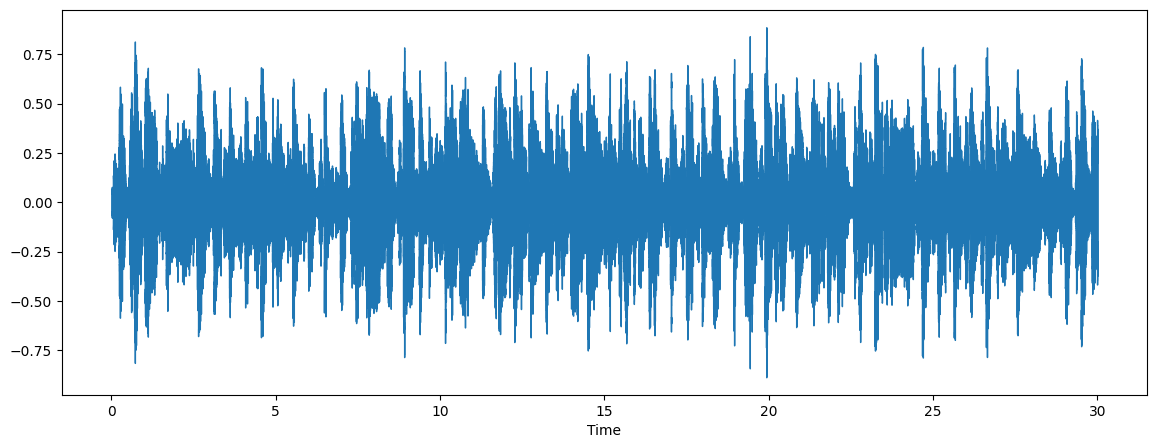

In [23]:
y,sr = librosa.load(random_file_name,sr=44100)
plt.figure(figsize=(14,5))
librosa.display.waveshow(y,sr=sr)

In [24]:
y.shape

(1323588,)

## Playing Sound

In [25]:
from IPython.display import Audio
Audio(data=y,rate=sr)

In [26]:
y

array([ 0.00734921,  0.01335782,  0.01657648, ..., -0.07293833,
       -0.06308185, -0.03151622], dtype=float32)

### Doing Visualization on chunks of Audio

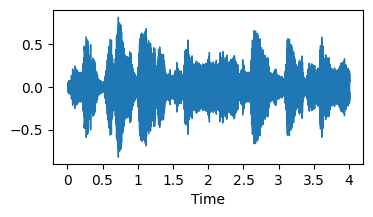

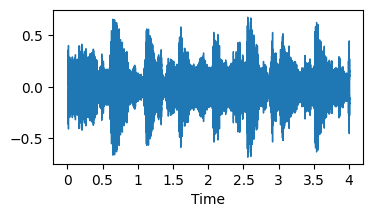

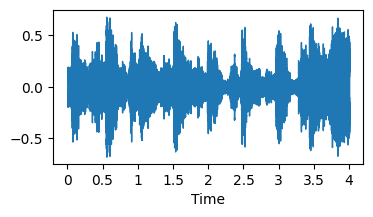

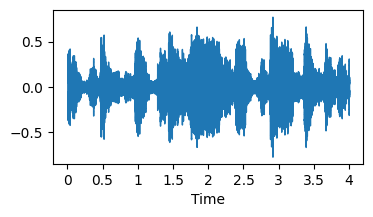

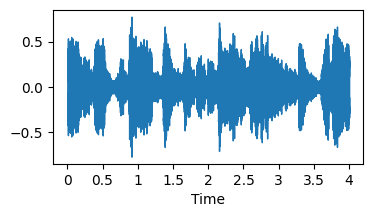

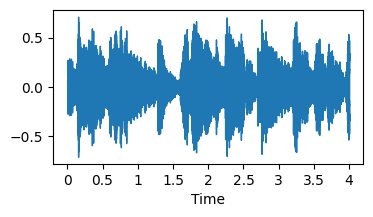

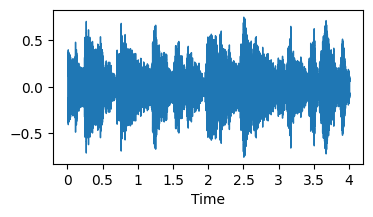

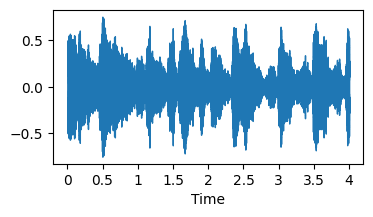

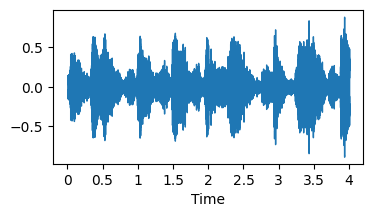

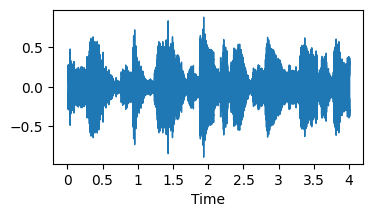

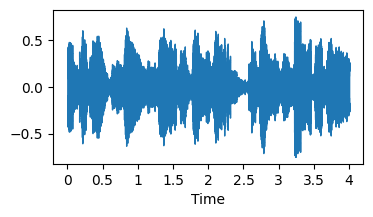

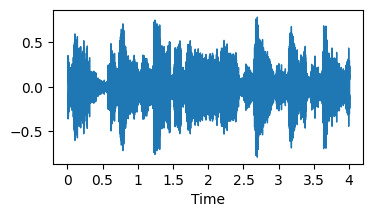

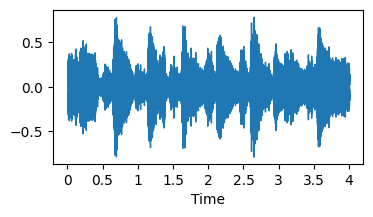

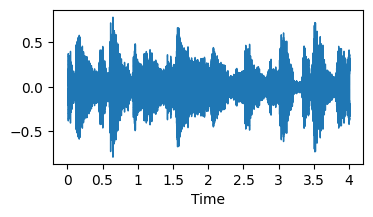

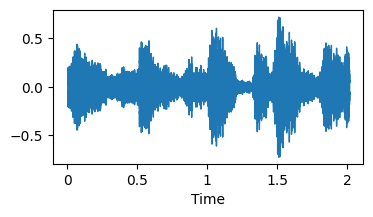

In [27]:
audio_path = "/content/Data/genres_original/blues/blues.00000.wav"
y, sr = librosa.load(audio_path, sr=None)

chunk_duration = 4
overlap_duration = 2

chunk_samples = chunk_duration * sr
overlap_samples = overlap_duration * sr

num_chunks = int(np.ceil((len(y) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

for i in range(num_chunks):
    start = i * (chunk_samples - overlap_samples)
    end = start + chunk_samples

    chunk = y[start:end]
    plt.figure(figsize=(4, 2))
    librosa.display.waveshow(chunk, sr=sr)
    plt.show()


## Melspectrogram Visualization

In [28]:
#Plotting Melspectrogram of Entire Audio
def plot_melespectrogram(y,sr):
    #Compute spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y,sr=sr)
    #Convert to decibels (log scale)
    spectrogram_db = librosa.power_to_db(spectrogram,ref=np.max)
    #Visualize the spectrogram
    plt.figure(figsize=(10,4))
    librosa.display.specshow(spectrogram_db,sr=sr,x_axis='time',y_axis='mel')
    plt.colorbar(format='%2.0f dB')
    plt.title("Spectrogram")
    plt.tight_layout()
    plt.show()


In [29]:
random_file_name = "/content/Data/genres_original/blues/blues.00000.wav"
y,sr = librosa.load(random_file_name,sr=44100)

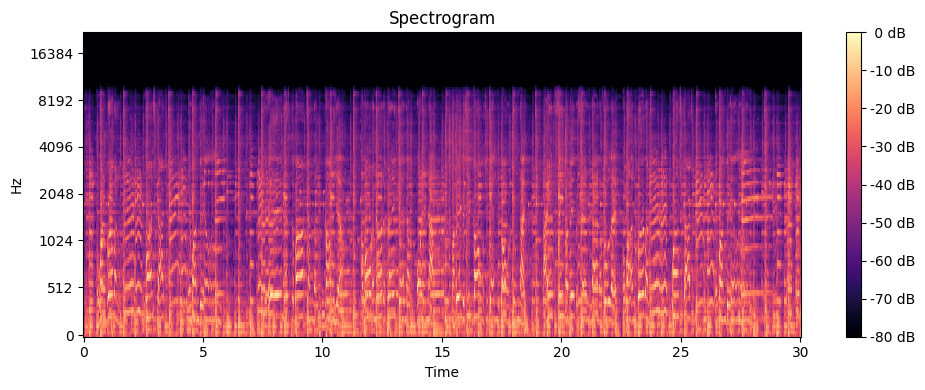

In [30]:
plot_melespectrogram(y,sr)

In [31]:
def plot_melspectrogram_chunks(y,sr):
    #define the duration of each chunk and overlap
    chunk_duration = 4
    overlap_duration = 2

    #Convert duration to sample
    chunk_samples = chunk_duration * sr
    overlap_samples = overlap_duration * sr

    #Calculate the number of chunks
    num_chunks = int(np.ceil((len(y)-chunk_samples)/(chunk_samples-overlap_samples)))+1

    #iterate over each chunks
    for i in range(num_chunks):
        #Calculate start and end indices of the chunk
        start = i*(chunk_samples-overlap_samples)
        end = start+chunk_samples
        #Extract the chunk audio
        chunk = y[start:end]
        #Melspectrogram part
        spectrogram = librosa.feature.melspectrogram(y=chunk,sr=sr)
        print(spectrogram.shape)
        spectrogram_db = librosa.power_to_db(spectrogram,ref=np.max)
        #Visualize the spectrogram
        plt.figure(figsize=(10,4))
        librosa.display.specshow(spectrogram_db,sr=sr,x_axis='time',y_axis='mel')
        plt.colorbar(format='%2.0f dB')
        plt.title("Spectrogram")
        plt.tight_layout()
        plt.show()

In [32]:
y,sr = librosa.load(random_file_name,sr=44100)

(128, 345)


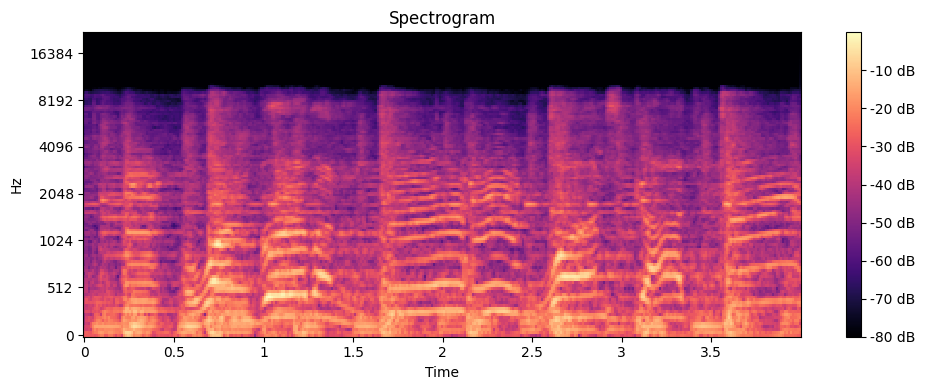

(128, 345)


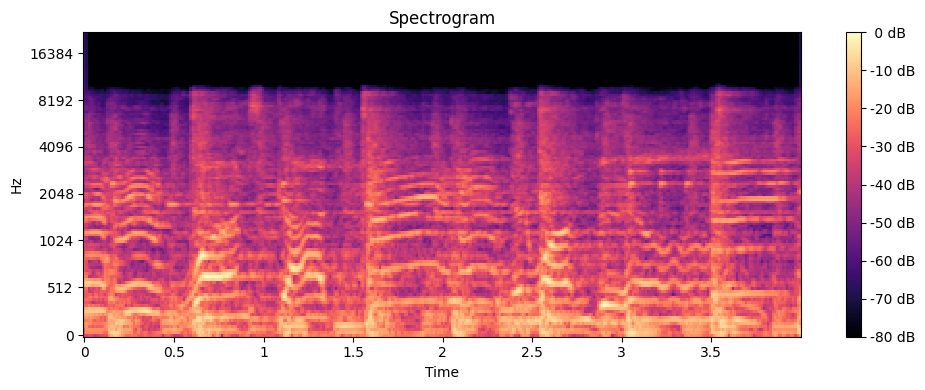

(128, 345)


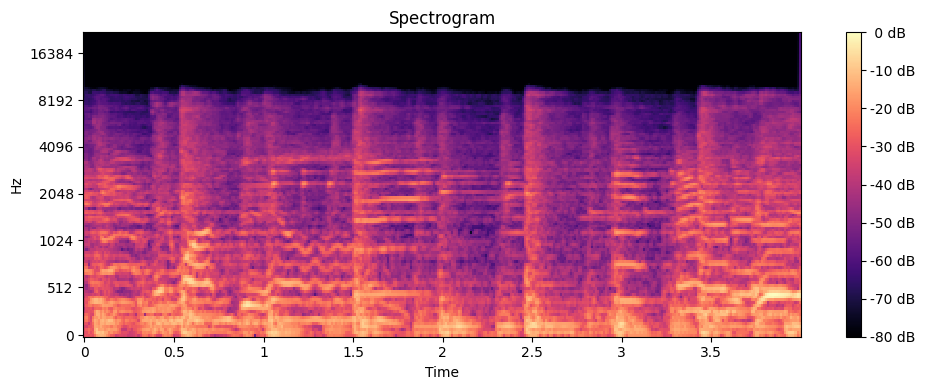

(128, 345)


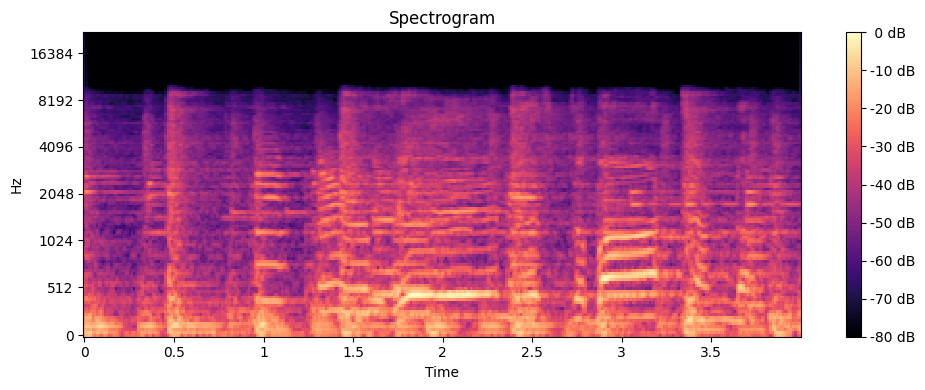

(128, 345)


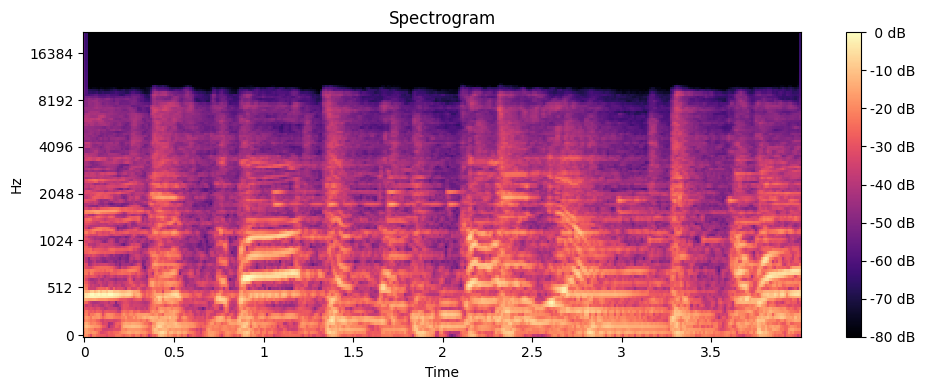

(128, 345)


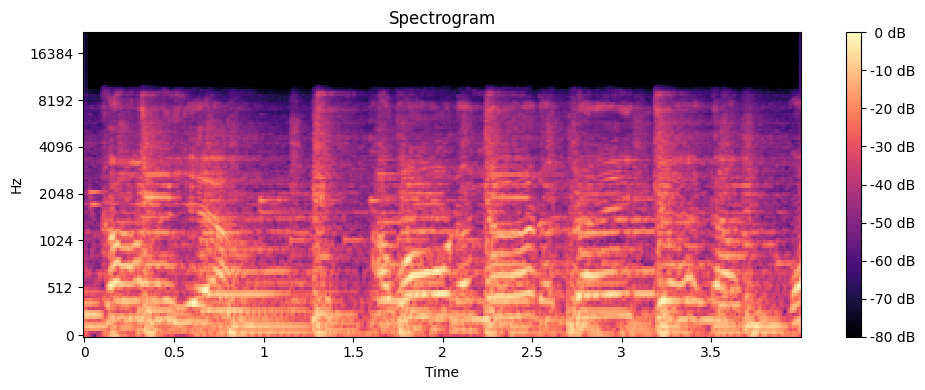

(128, 345)


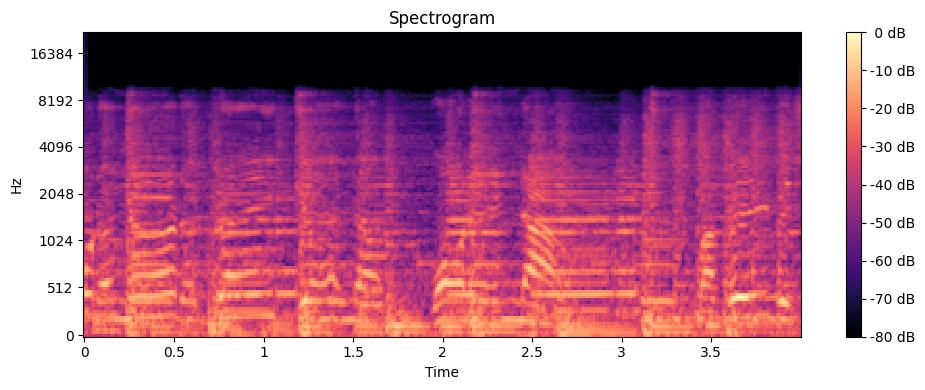

(128, 345)


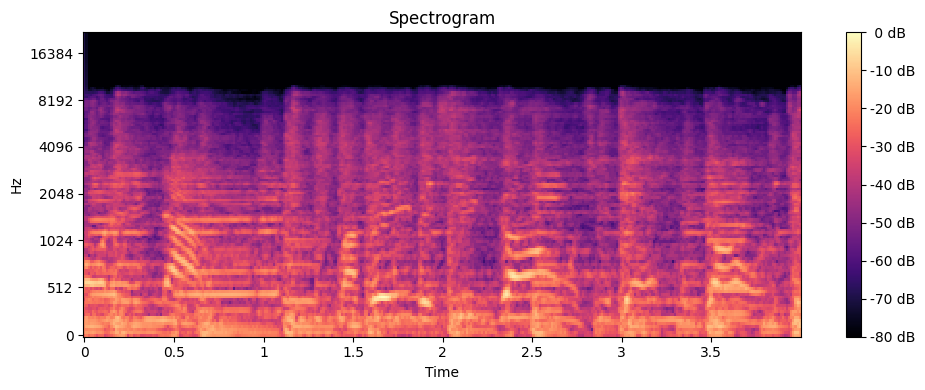

(128, 345)


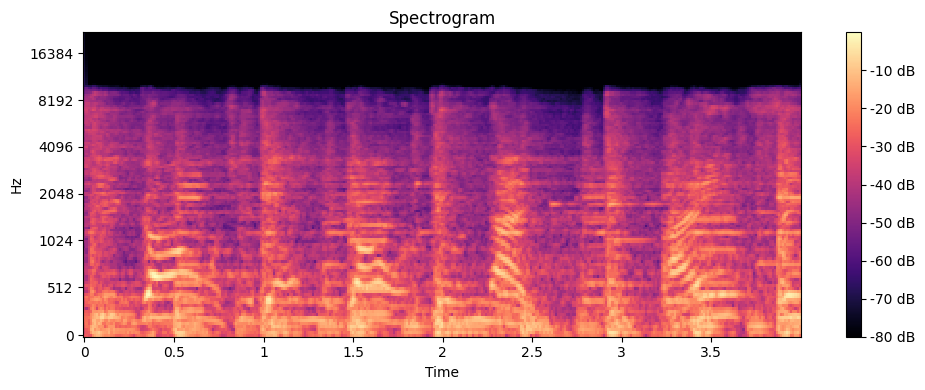

(128, 345)


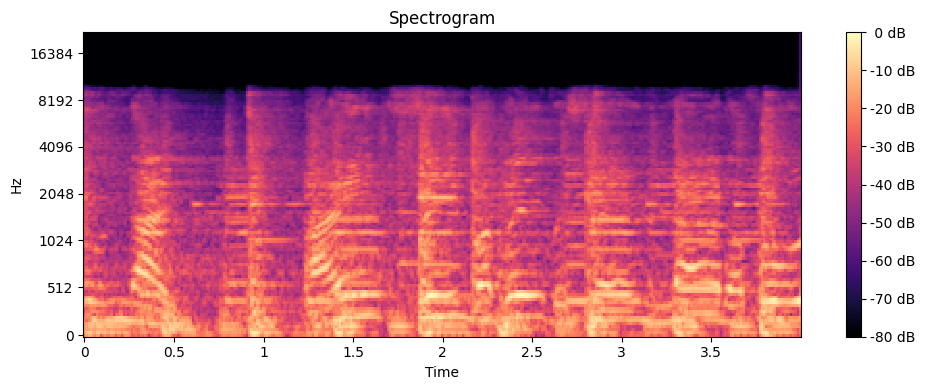

(128, 345)


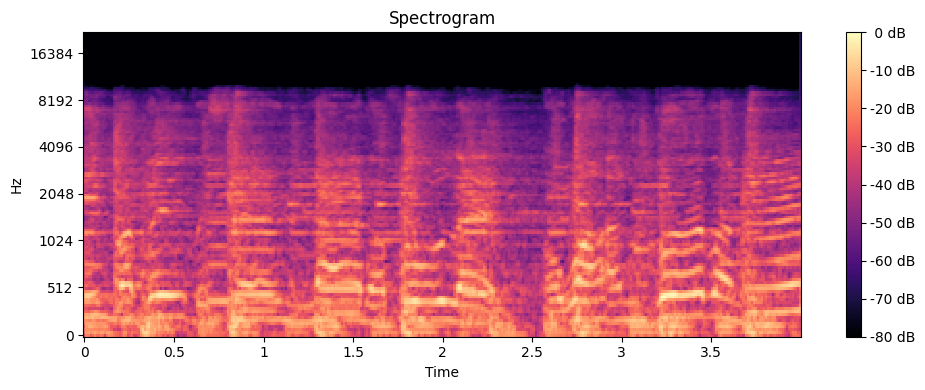

(128, 345)


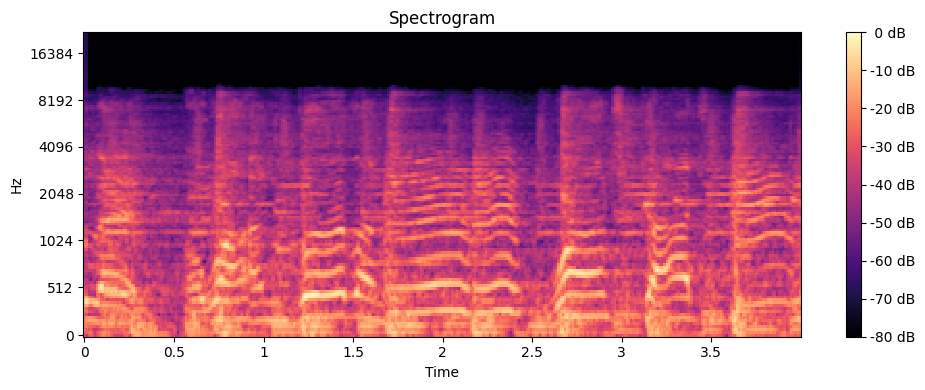

(128, 345)


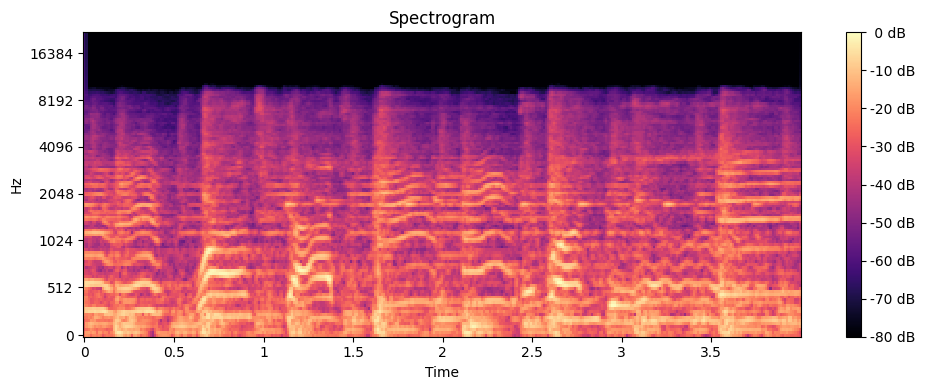

(128, 345)


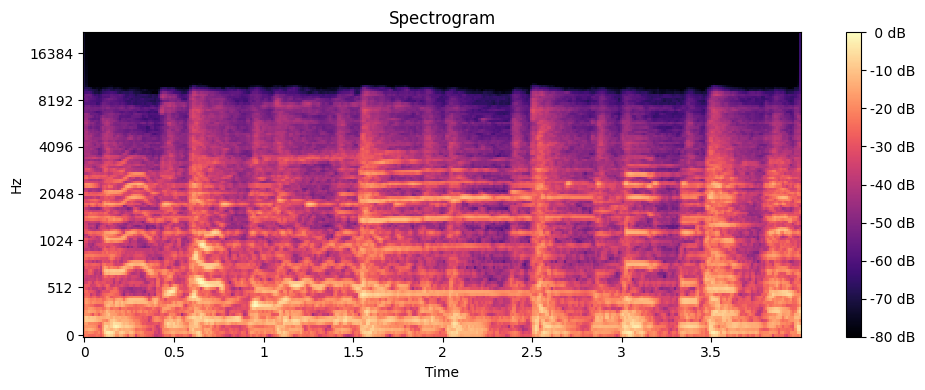

(128, 174)


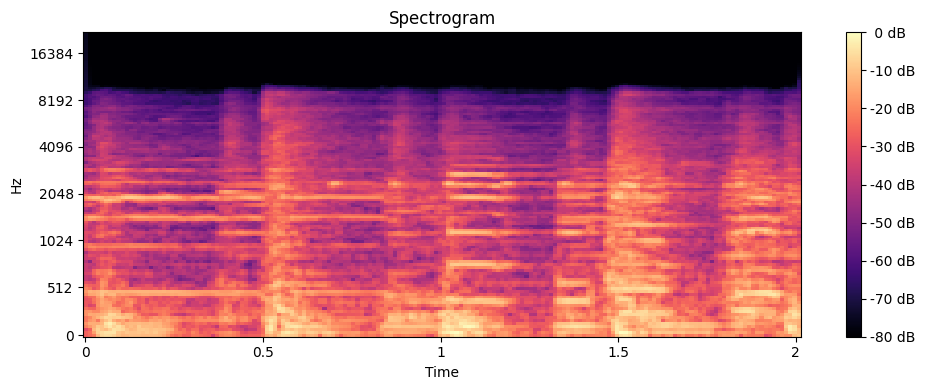

In [33]:
plot_melspectrogram_chunks(y,sr)

## Data Preprocessing - Final

In [34]:
data_dir = "Data/genres_original"
classes = ['blues', 'classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

In [40]:
#Load and preprocess audio data
def load_and_preprocess_data(data_dir,classes,target_shape=(150,150)):
    data=[]
    labels=[]

    for i_class,class_name in enumerate(classes):
        class_dir = os.path.join(data_dir,class_name)
        print("Processing--",class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir,filename)
                try:
                    audio_data, sample_rate = sf.read(file_path)
                except sf.LibsndfileError as e:
                    print(f"Error loading {file_path}: {e}")
                    continue

                chunk_duration = 4
                overlap_duration = 2

                chunk_samples = chunk_duration * sample_rate
                overlap_samples = overlap_duration * sample_rate

                num_chunks = int(np.ceil((len(audio_data)-chunk_samples)/(chunk_samples-overlap_samples)))+1

                #iterate over each chunks
                for i in range(num_chunks):
                    start = i*(chunk_samples-overlap_samples)
                    end = start+chunk_samples
                    chunk = audio_data[start:end]
                    mel_spectrogram = librosa.feature.melspectrogram(y=chunk,sr=sample_rate)
                    mel_spectrogram = resize(np.expand_dims(mel_spectrogram,axis=-1),target_shape)
                    data.append(mel_spectrogram)
                    labels.append(i_class)
    #Return
    return np.array(data),np.array(labels)

In [41]:
data,labels = load_and_preprocess_data(data_dir,classes)

Processing-- blues
Processing-- classical
Processing-- country
Processing-- disco
Processing-- hiphop
Processing-- jazz
Error loading Data/genres_original/jazz/jazz.00054.wav: Error opening 'Data/genres_original/jazz/jazz.00054.wav': Format not recognised.
Processing-- metal
Processing-- pop
Processing-- reggae
Processing-- rock


In [42]:
data.shape

(14975, 150, 150, 1)

In [43]:
labels.shape

(14975,)

In [44]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels,num_classes = len(classes)) # Converting labels to one-hot encoding
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [45]:
labels.shape

(14975, 10)

## Splitting of Dataset into Training and Test set

In [46]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(data,labels,test_size=0.2,random_state=42)

# Building Model

In [65]:
model = tf.keras.models.Sequential()

In [66]:
X_train[0].shape

(150, 150, 1)

In [67]:
model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=X_train[0].shape))
model.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [68]:
model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [69]:
model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [70]:
model.add(Dropout(0.3))

In [71]:
model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [72]:
model.add(Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=512,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [73]:
model.add(Dropout(0.3))

In [74]:
model.add(Flatten())

In [75]:
model.add(Dense(units=1200,activation='relu'))

In [76]:
model.add(Dropout(0.45))

In [77]:
#Output layer
model.add(Dense(units=len(classes),activation='softmax'))

In [78]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 148, 148, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 74, 74, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 72, 72, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 36, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 34, 34, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 17, 17, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 15, 15, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 7, 7, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 5, 5, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1200)                │       2,458,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │          12,010 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [80]:
#Training Model
training_history = model.fit(X_train,Y_train,epochs=30,batch_size=32,validation_data=(X_test,Y_test))

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 62s 119ms/step - accuracy: 0.1987 - loss: 2.1616 - val_accuracy: 0.3987 - val_loss: 1.6460
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 51s 74ms/step - accuracy: 0.4370 - loss: 1.5715 - val_accuracy: 0.6020 - val_loss: 1.1844
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/step - accuracy: 0.5715 - loss: 1.2082 - val_accuracy: 0.6484 - val_loss: 1.0389
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - accuracy: 0.6595 - loss: 0.9915 - val_accuracy: 0.6578 - val_loss: 1.0178
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.7240 - loss: 0.8089 - val_accuracy: 0.7492 - val_loss: 0.7845
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/step - accuracy: 0.7534 - loss: 0.7256 - val_accuracy: 0.7910 - val_loss: 0.6458
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.8000 - loss: 0.5887 - val_accuracy: 0.8017 - val_loss: 0.5744
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - accuracy: 0.8335 - loss: 0.4933 -

In [81]:
model.save("Trained_model.keras")
model.save("Trained_model.h5")

In [82]:
training_history.history

{'accuracy': [0.25767946243286133,
  0.47470784187316895,
  0.5924874544143677,
  0.6697829961776733,
  0.7248747944831848,
  0.7664440870285034,
  0.7993322014808655,
  0.8372287154197693,
  0.864858090877533,
  0.8848915100097656,
  0.9015859961509705,
  0.905926525592804,
  0.9285475611686707,
  0.9334724545478821,
  0.945909857749939,
  0.9503338932991028,
  0.9534223675727844,
  0.9597662687301636,
  0.9651085138320923,
  0.9666110277175903,
  0.9727045297622681,
  0.973038375377655,
  0.9745408892631531,
  0.9758764505386353,
  0.9765442609786987,
  0.9773789644241333,
  0.9801335334777832,
  0.9826377034187317,
  0.9802170395851135,
  0.982721209526062],
 'loss': [2.0060272216796875,
  1.4759416580200195,
  1.1663261651992798,
  0.9643020629882812,
  0.8095777034759521,
  0.6812248229980469,
  0.5891737937927246,
  0.48476436734199524,
  0.4059184193611145,
  0.34867969155311584,
  0.2969568967819214,
  0.2712095379829407,
  0.21819934248924255,
  0.1972513645887375,
  0.1626581

In [83]:
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)

In [84]:
X_train

array([[[[7.43146286e+01],
         [3.58040543e+01],
         [6.89977980e+00],
         ...,
         [1.66694679e+01],
         [8.44135895e+01],
         [6.82972183e+01]],

        [[1.59073898e+02],
         [2.71222321e+02],
         [1.75872360e+02],
         ...,
         [2.64613586e+02],
         [4.84409973e+02],
         [1.35413284e+02]],

        [[1.14122490e+02],
         [2.59784485e+02],
         [2.23048416e+02],
         ...,
         [3.65986298e+02],
         [6.03175415e+02],
         [1.09239693e+02]],

        ...,

        [[4.85650293e-04],
         [9.92095884e-05],
         [3.71904378e-07],
         ...,
         [4.74989338e-06],
         [4.77019494e-05],
         [5.33868966e-04]],

        [[4.82552045e-04],
         [9.82724159e-05],
         [3.77658829e-08],
         ...,
         [3.70506228e-07],
         [4.11220390e-05],
         [5.05443604e-04]],

        [[4.79678245e-04],
         [9.76490992e-05],
         [5.69192249e-09],
         ...,
 

In [85]:
model = tf.keras.models.load_model("Trained_model.h5")
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 148, 148, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 74, 74, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 72, 72, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 36, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 34, 34, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 17, 17, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 15, 15, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 7, 7, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 5, 5, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1200)                │       2,458,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │          12,010 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 7,182,460 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [86]:
import json
with open("training_hist.json",'r') as json_file:
    training_history_data = json.load(json_file)

In [87]:
training_history_data.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

## Model Evaluation - I

In [88]:
#Model evaluation on Training set
train_loss,train_accuracy = model.evaluate(X_train,Y_train)

375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9976 - loss: 0.0109


In [89]:
train_loss,train_accuracy

(0.011290464550256729, 0.9971619248390198)

In [90]:
#Model evaluation on Validation set
val_loss,val_accuracy = model.evaluate(X_test,Y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9240 - loss: 0.3043


In [91]:
val_loss,val_accuracy

(0.3243134617805481, 0.9202003479003906)

In [92]:
training_history_data['val_loss']

[1.6459593772888184,
 1.1844087839126587,
 1.0389162302017212,
 1.0177721977233887,
 0.7845485210418701,
 0.6458115577697754,
 0.5743931531906128,
 0.5370222926139832,
 0.5177963972091675,
 0.47903382778167725,
 0.4205605983734131,
 0.3822180926799774,
 0.3915715217590332,
 0.3743639290332794,
 0.32669928669929504,
 0.37712210416793823,
 0.3270259499549866,
 0.3846167325973511,
 0.3263114392757416,
 0.4167501628398895,
 0.41684484481811523,
 0.4492039084434509,
 0.3162972927093506,
 0.48453444242477417,
 0.3506350517272949,
 0.35361918807029724,
 0.31957635283470154,
 0.44305890798568726,
 0.4040507376194,
 0.3243134617805481]

## Accuracy and Loss Visualization

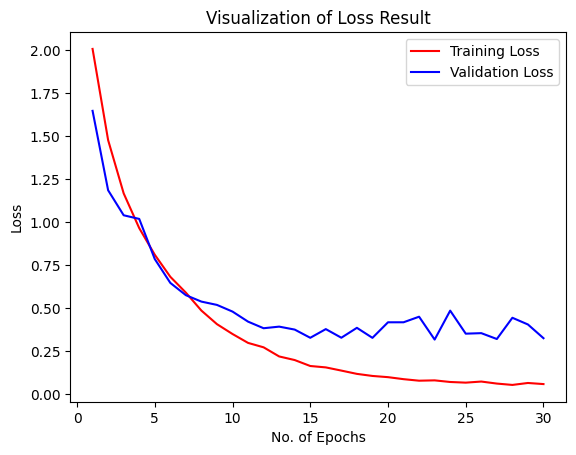

In [93]:
#Visualization of Loss
epochs = [i for i in range(1,31)]
plt.plot(epochs,training_history_data['loss'],label="Training Loss",color='red')
plt.plot(epochs,training_history_data['val_loss'],label="Validation Loss",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Visualization of Loss Result")
plt.legend()
plt.show()

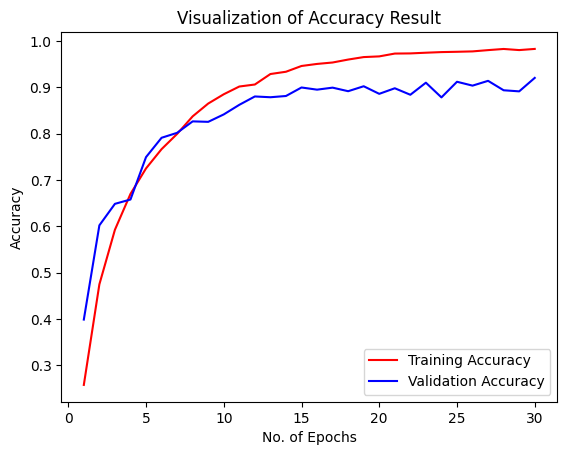

In [94]:
#Visualization of Accuracy
epochs = [i for i in range(1,31)]
plt.plot(epochs,training_history_data['accuracy'],label="Training Accuracy",color='red')
plt.plot(epochs,training_history_data['val_accuracy'],label="Validation Accuracy",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Visualization of Accuracy Result")
plt.legend()
plt.show()

## Precision,Recall,Confusion Matrix - Model Evaluation-II

In [95]:
X_test.shape

(2995, 150, 150, 1)

In [96]:
y_pred = model.predict(X_test)
y_pred

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


array([[1.8783406e-17, 2.3289442e-18, 2.2216076e-18, ..., 9.9999952e-01,
        2.8819676e-11, 2.8532921e-14],
       [1.0753075e-12, 3.8058840e-14, 1.4267684e-14, ..., 3.4470189e-13,
        1.6799253e-11, 1.3510293e-08],
       [1.6553916e-11, 1.4223262e-13, 3.1019082e-10, ..., 4.3593821e-14,
        6.8949763e-12, 2.3162536e-06],
       ...,
       [9.5787364e-01, 4.2191937e-07, 4.0462144e-02, ..., 1.7910851e-04,
        7.4666034e-04, 2.0091027e-05],
       [6.4010833e-06, 9.9978846e-01, 7.4863010e-06, ..., 2.3223017e-06,
        2.7062348e-05, 5.3114336e-06],
       [1.4919107e-17, 1.3716816e-20, 5.0352542e-20, ..., 7.2197272e-13,
        2.7281680e-10, 3.8505765e-11]], dtype=float32)

In [97]:
y_pred.shape

(2995, 10)

In [98]:
predicted_categories = np.argmax(y_pred,axis=1)
predicted_categories

array([7, 6, 6, ..., 0, 1, 4])

In [99]:
Y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [100]:
Y_test.shape

(2995, 10)

In [101]:
true_categories = np.argmax(Y_test,axis=1)
true_categories

array([7, 6, 6, ..., 0, 1, 4])

In [102]:
classes

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [103]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(true_categories,predicted_categories)
# Precision Recall F1score
print(classification_report(true_categories,predicted_categories,target_names=classes))

              precision    recall  f1-score   support

       blues       0.90      0.93      0.91       302
   classical       0.97      0.96      0.96       298
     country       0.89      0.86      0.88       317
       disco       0.97      0.88      0.92       312
      hiphop       0.94      0.95      0.95       277
        jazz       0.94      0.90      0.92       311
       metal       0.96      0.93      0.94       302
         pop       0.93      0.93      0.93       289
      reggae       0.89      0.95      0.92       296
        rock       0.82      0.92      0.87       291

    accuracy                           0.92      2995
   macro avg       0.92      0.92      0.92      2995
weighted avg       0.92      0.92      0.92      2995



## Confusion Matrix Visualization

In [104]:
cm

array([[280,   1,   5,   1,   2,   1,   1,   1,   7,   3],
       [  2, 285,   2,   1,   0,   5,   0,   0,   0,   3],
       [ 11,   0, 272,   1,   0,   4,   0,   4,   4,  21],
       [  1,   2,   0, 275,   4,   0,   0,   7,  11,  12],
       [  0,   0,   0,   0, 264,   1,   6,   1,   5,   0],
       [  8,   5,  11,   0,   0, 281,   0,   2,   3,   1],
       [  3,   0,   0,   1,   1,   0, 281,   0,   0,  16],
       [  3,   0,   5,   0,   8,   2,   0, 270,   0,   1],
       [  2,   0,   6,   0,   2,   1,   0,   3, 280,   2],
       [  2,   0,   3,   5,   0,   3,   6,   1,   3, 268]])

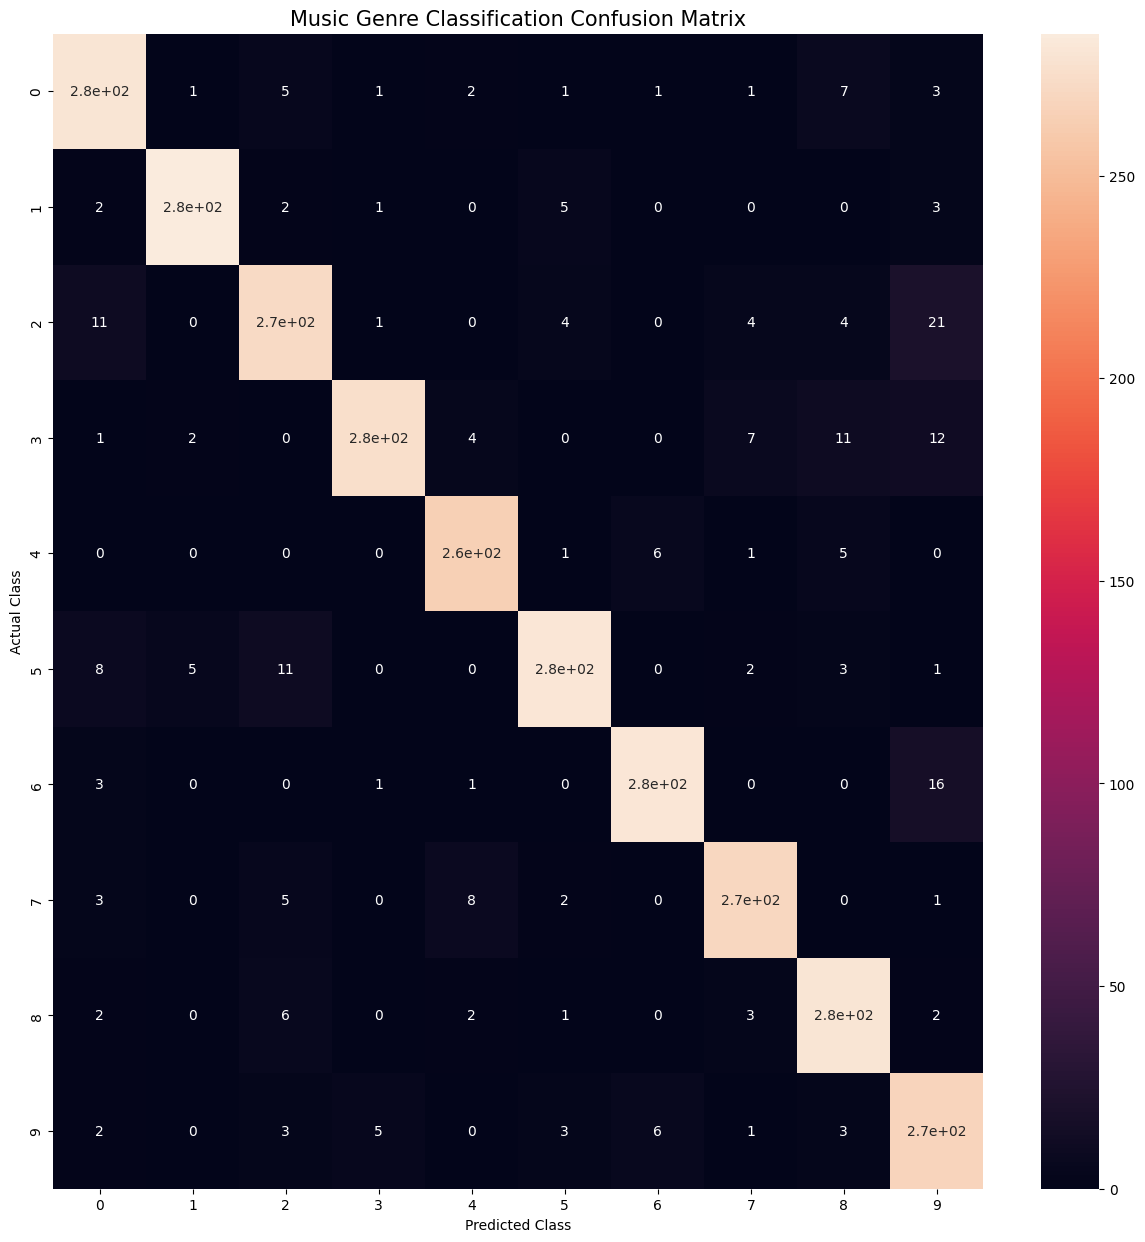

In [105]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(cm,annot=True,annot_kws={"size":10})
plt.xlabel("Predicted Class",fontsize=10)
plt.ylabel("Actual Class",fontsize=10)
plt.title("Music Genre Classification Confusion Matrix",fontsize=15)
plt.show()